##  Geospatial Exploratory Data Analysis

This section focuses on understanding the **spatial characteristics of housing prices** using geographic coordinates and engineered location-based features. Visualizations were created to examine the overall geographic distribution of properties, spatial clustering of house prices, and variations across different price quantiles.

Spatial density plots were used to analyze how housing concentration varies across locations and how local density relates to property values. The impact of proximity to the city center on house prices was also explored to capture urban accessibility effects. Finally, a smooth spatial price surface was generated to visualize broad regional price trends and identify high- and low-value zones across the study area.

These geospatial insights help establish the importance of **location-driven patterns**, which are later complemented by satellite imagery in the multimodal framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


BASE_PATH = "/content/drive/MyDrive/multimodal-real-estate/data/processed"

# Load tabular data
X = pd.read_csv(f"{BASE_PATH}/X_train.csv")
y = pd.read_csv(f"{BASE_PATH}/y_train.csv")

# Merge target with features
df = X.copy()
df["price"] = y.iloc[:, 0]


print("Dataset shape:", df.shape)
df[["lat", "long", "price"]].head()


Dataset shape: (12967, 33)


lat     long      price
0  47.5297 -121.827  12.566195
1  47.5596 -122.315  12.899222
2  47.6378 -122.065  13.480039
3  47.7117 -122.278  13.853770
4  47.5605 -121.905  14.437162

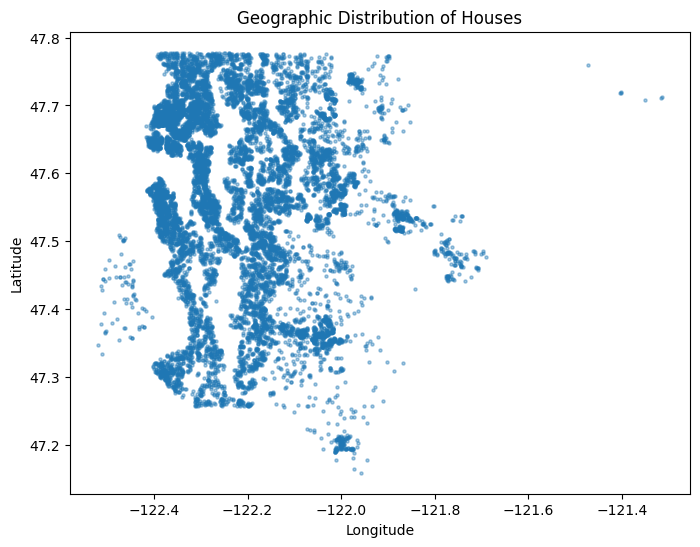

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df["long"], df["lat"], s=5, alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of Houses")
plt.show()


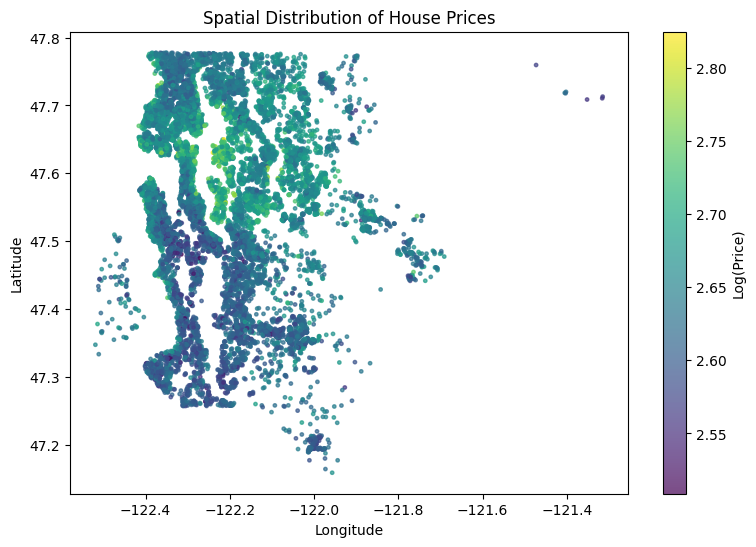

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Add log-price for better visualization
df["log_price"] = np.log1p(df["price"])

plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    df["long"],
    df["lat"],
    c=df["log_price"],
    cmap="viridis",
    s=6,
    alpha=0.7
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of House Prices")
cbar = plt.colorbar(scatter)
cbar.set_label("Log(Price)")

plt.show()


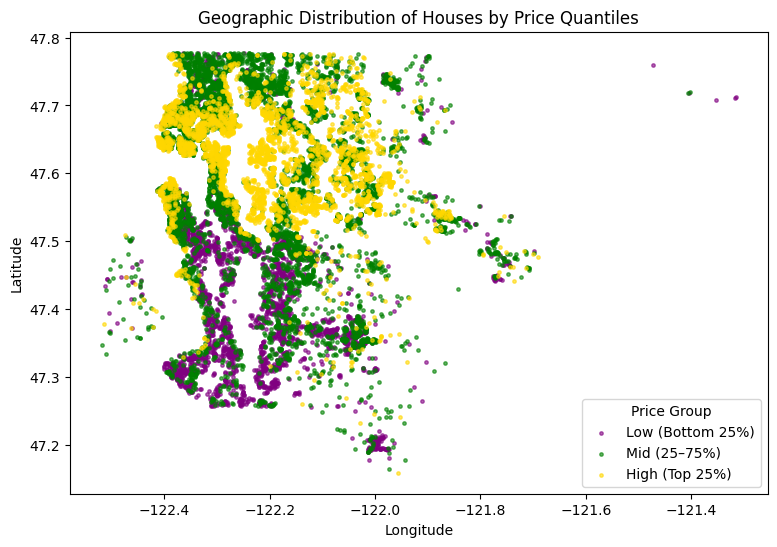

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create price quantiles
df["price_quantile"] = pd.qcut(
    df["price"],
    q=[0, 0.25, 0.75, 1.0],
    labels=["Low (Bottom 25%)", "Mid (25–75%)", "High (Top 25%)"]
)

# Color mapping for clarity
color_map = {
    "Low (Bottom 25%)": "purple",
    "Mid (25–75%)": "green",
    "High (Top 25%)": "gold"
}

plt.figure(figsize=(9, 6))

for label, color in color_map.items():
    subset = df[df["price_quantile"] == label]
    plt.scatter(
        subset["long"],
        subset["lat"],
        s=6,
        alpha=0.6,
        label=label,
        color=color
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of Houses by Price Quantiles")
plt.legend(title="Price Group")
plt.show()


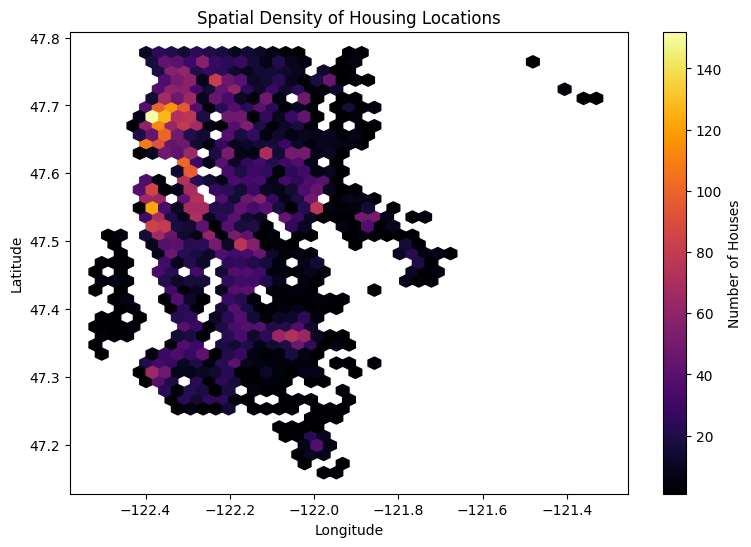

In [ ]:
plt.figure(figsize=(9, 6))

hb = plt.hexbin(
    df["long"],
    df["lat"],
    gridsize=40,
    cmap="inferno",
    mincnt=1
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Density of Housing Locations")
cb = plt.colorbar(hb)
cb.set_label("Number of Houses")

plt.show()


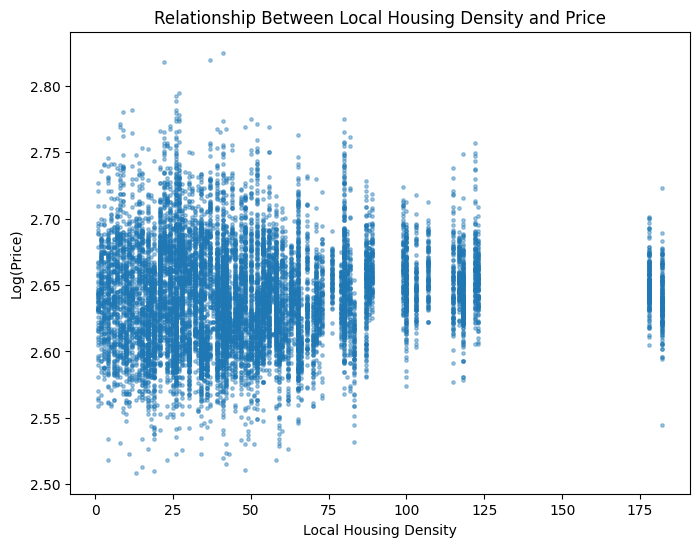

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

# Create a 2D density grid
bins = 40
density, xedges, yedges, _ = binned_statistic_2d(
    df["long"],
    df["lat"],
    None,
    statistic="count",
    bins=bins
)

# Assign each house a local density value
x_idx = np.digitize(df["long"], xedges) - 1
y_idx = np.digitize(df["lat"], yedges) - 1

# Clip indices to avoid out-of-range errors
x_idx = np.clip(x_idx, 0, density.shape[0] - 1)
y_idx = np.clip(y_idx, 0, density.shape[1] - 1)

df["local_density"] = density[x_idx, y_idx]

# Plot density vs log(price)
plt.figure(figsize=(8, 6))
plt.scatter(
    df["local_density"],
    np.log1p(df["price"]),
    s=6,
    alpha=0.4
)

plt.xlabel("Local Housing Density")
plt.ylabel("Log(Price)")
plt.title("Relationship Between Local Housing Density and Price")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute geographic center of all houses
center_lat = df["lat"].mean()
center_long = df["long"].mean()

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Distance of each house from center
df["distance_from_center_km"] = haversine(
    df["lat"].values,
    df["long"].values,
    center_lat,
    center_long
)

df[["distance_from_center_km", "price"]].head()


distance_from_center_km      price
0                29.240603  12.566195
1                 7.589303  12.899222
2                14.078493  13.480039
3                17.470580  13.853770
4                23.176190  14.437162

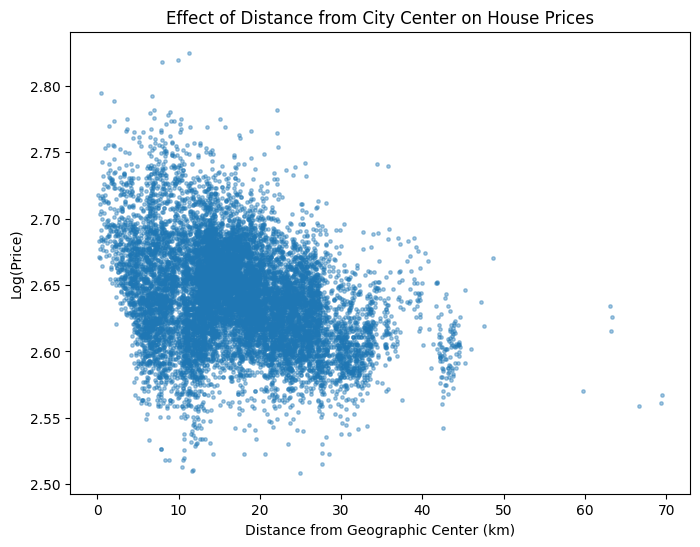

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(
    df["distance_from_center_km"],
    np.log1p(df["price"]),
    s=6,
    alpha=0.4
)

plt.xlabel("Distance from Geographic Center (km)")
plt.ylabel("Log(Price)")
plt.title("Effect of Distance from City Center on House Prices")
plt.show()


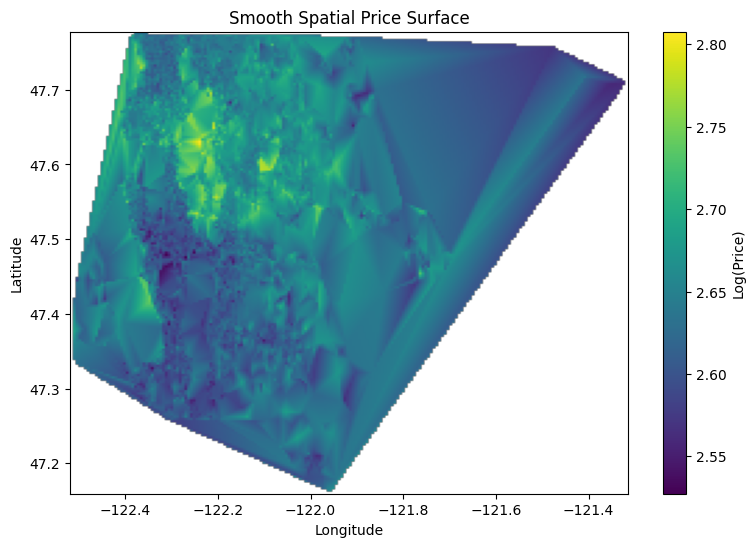

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Prepare data
points = np.column_stack((df["long"], df["lat"]))
values = np.log1p(df["price"])  # log-price for stability

# Create grid
grid_lon = np.linspace(df["long"].min(), df["long"].max(), 200)
grid_lat = np.linspace(df["lat"].min(), df["lat"].max(), 200)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

# Interpolate price surface
grid_price = griddata(
    points,
    values,
    (grid_lon, grid_lat),
    method="linear"
)

# Plot
plt.figure(figsize=(9, 6))
plt.imshow(
    grid_price,
    extent=(df["long"].min(), df["long"].max(),
            df["lat"].min(), df["lat"].max()),
    origin="lower",
    cmap="viridis",
    aspect="auto"
)

plt.colorbar(label="Log(Price)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Smooth Spatial Price Surface")
plt.show()


#Visual EDA

In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Paths
BASE_PATH = "/content/drive/MyDrive/multimodal-real-estate"
IMAGE_DIR = f"{BASE_PATH}/data/raw/images/train"
RAW_TAB_PATH = f"{BASE_PATH}/data/raw/train(1).xlsx"

# Load raw tabular data (FULL dataset)
df_raw = pd.read_excel(RAW_TAB_PATH)

print("Raw data shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

# Load image filenames
image_files = sorted(os.listdir(IMAGE_DIR))
print("Total images:", len(image_files))

df_raw.head()


Raw data shape: (16209, 21)
Columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Total images: 16110


id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      8638     2.0           0     0  ...      8        1720              0   
3       705     2.0           0     0  ...      7        1150             90   
4     13356     1.0           0     0  ...      7        1280              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1961             0    98055  47.4362 -122.187           1660   
1      1992             0    98031  47.4034 -122.187           1720   
2      1994             0    98003  47.2704 -122.313           1870   
3      2009             0    98027  47.5321 -122.073           1240   
4      1994             0    98042  47.3715 -122.074           1590   

   sqft_lot15  
0        9240  
1        3605  
2        7455  
3         750  
4        8071  

[5 rows x 21 columns]

In [ ]:
def show_image_grid_by_id(ids, title, n_cols=5, img_size=(128, 128)):
    n_images = len(ids)
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 3, n_rows * 3))

    for i, img_id in enumerate(ids):
        # Ensure filename matches: id_<value>.0.jpg
        img_name = f"id_{float(img_id)}.jpg"
        img_path = os.path.join(IMAGE_DIR, img_name)

        if not os.path.exists(img_path):
            # Skip missing files safely (very rare edge case)
            continue

        img = Image.open(img_path).resize(img_size)

        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


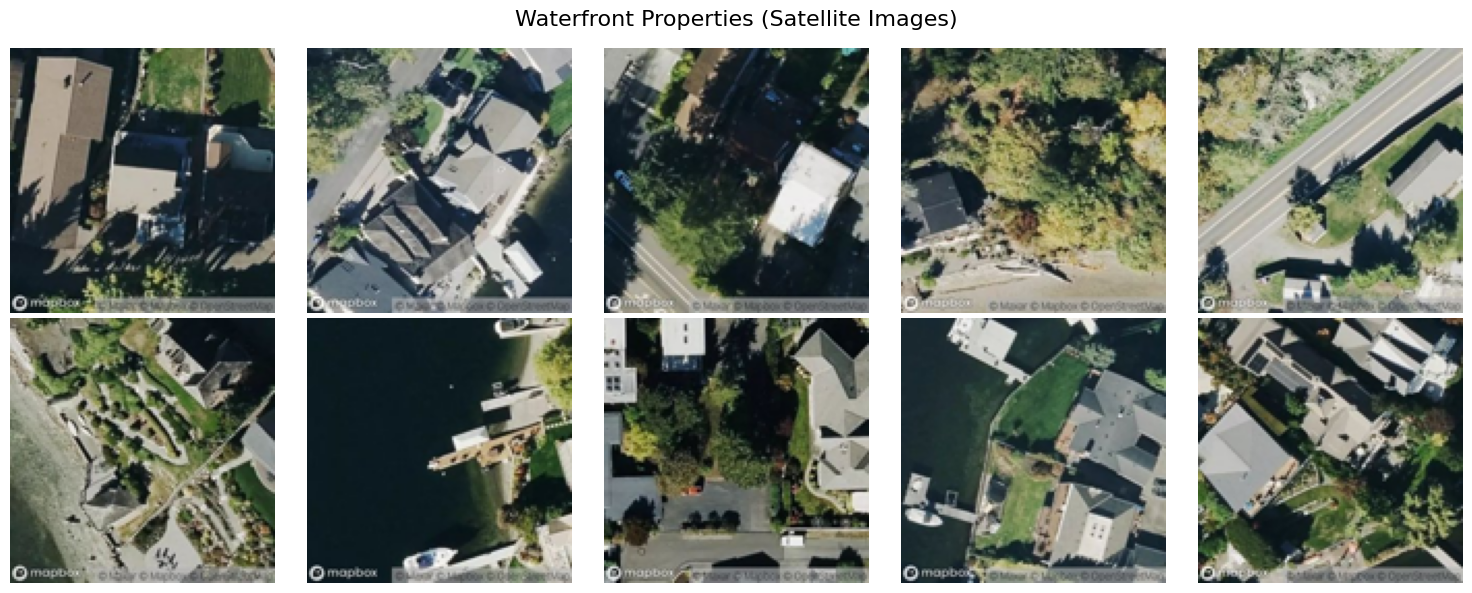

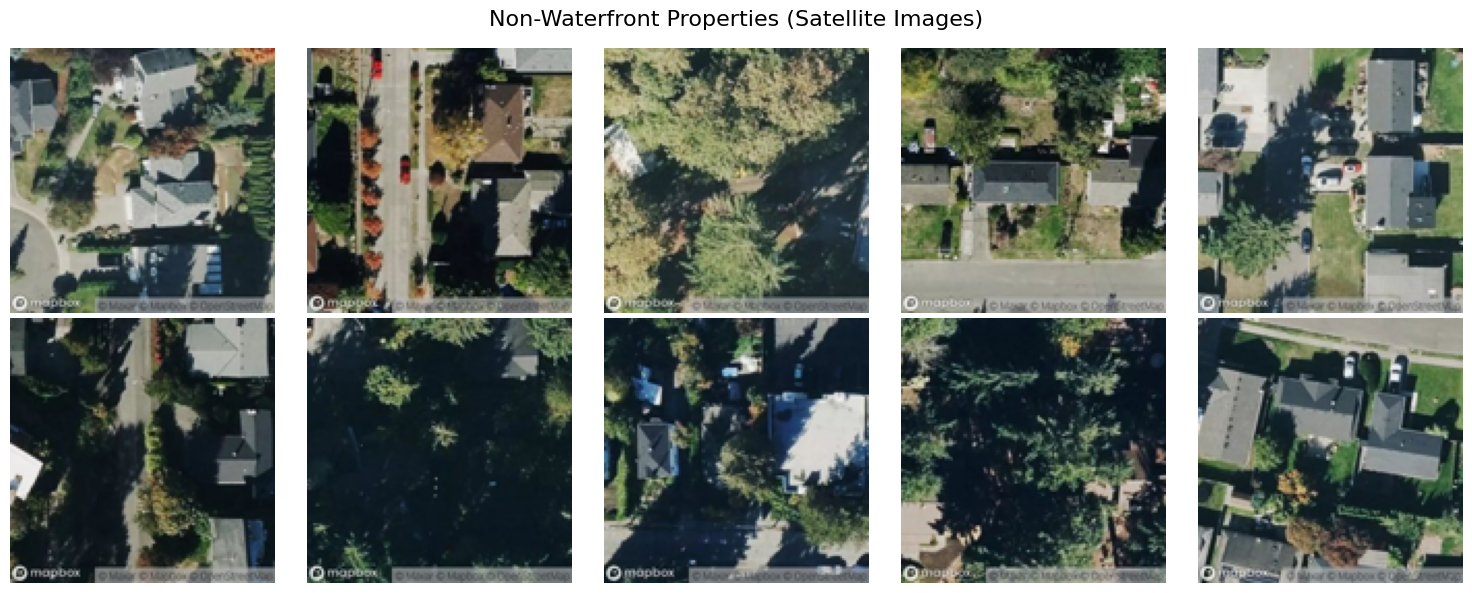

In [ ]:
# Split IDs based on waterfront feature
waterfront_ids = df_raw[df_raw["waterfront"] == 1]["id"].tolist()
non_waterfront_ids = df_raw[df_raw["waterfront"] == 0]["id"].tolist()

# Sample images
random.seed(42)
wf_sample = random.sample(waterfront_ids, min(10, len(waterfront_ids)))
non_wf_sample = random.sample(non_waterfront_ids, 10)

# Display
show_image_grid_by_id(wf_sample, "Waterfront Properties (Satellite Images)")
show_image_grid_by_id(non_wf_sample, "Non-Waterfront Properties (Satellite Images)")


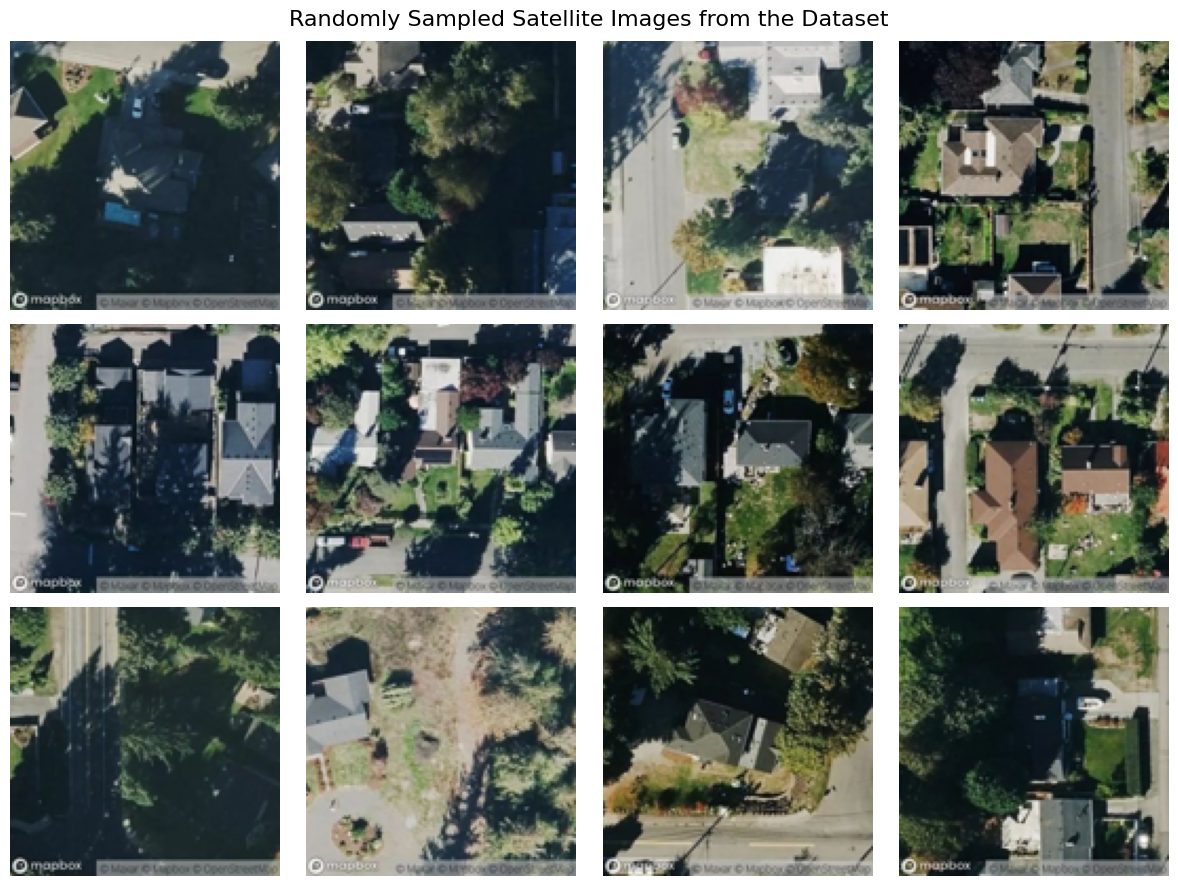

In [ ]:
import random

# Randomly sample from full raw dataset
random.seed(42)
random_ids = random.sample(df_raw["id"].tolist(), 12)

show_image_grid_by_id(
    random_ids,
    title="Randomly Sampled Satellite Images from the Dataset",
    n_cols=4
)


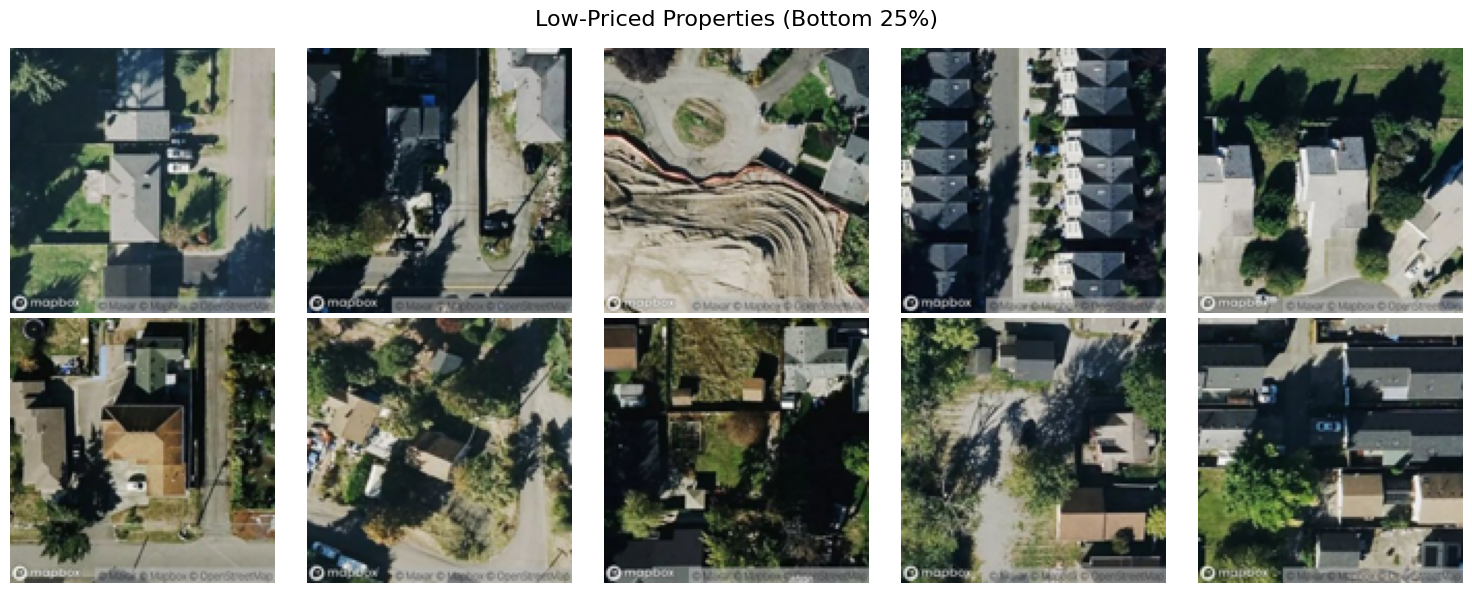

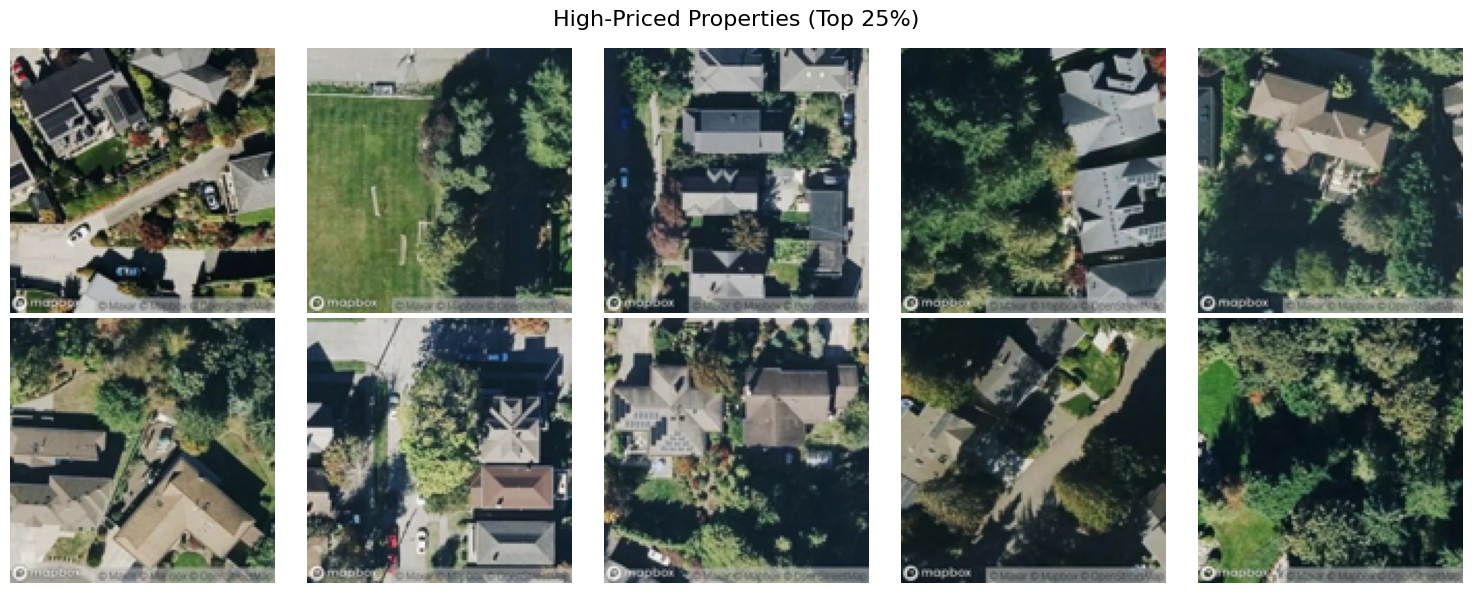

In [ ]:
# Define price quantiles
low_price_ids = df_raw[df_raw["price"] <= df_raw["price"].quantile(0.25)]["id"].tolist()
high_price_ids = df_raw[df_raw["price"] >= df_raw["price"].quantile(0.75)]["id"].tolist()

# Sample images
random.seed(42)
low_sample = random.sample(low_price_ids, 10)
high_sample = random.sample(high_price_ids, 10)

# Display
show_image_grid_by_id(
    low_sample,
    title="Low-Priced Properties (Bottom 25%)",
    n_cols=5
)

show_image_grid_by_id(
    high_sample,
    title="High-Priced Properties (Top 25%)",
    n_cols=5
)
